In [10]:
%load_ext autoreload
%autoreload 2
import kindis_tools as kd
 
kd.combine('\\E2W10-L10-24',2,10,0,False)

file = kd.datadir+"E2W10Lz100K.csv"
kd.stats_C(file,10,15)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
c= 0.26700, # of L's=2, L range=(8,9)
8=10, 9=10, 
----------------------------------
c= 0.27100, # of L's=15, L range=(10,24)
10=84, 11=15, 12=46, 13=15, 14=26, 15=15, 16=6, 17=6, 18=6, 19=6, 20=3, 21=5, 22=5, 23=5, 24=5, 
----------------------------------
c= 0.28000, # of L's=4, L range=(8,30)
8=10, 9=10, 29=5, 30=5, 
----------------------------------
c= 0.28100, # of L's=15, L range=(14,28)
14=6, 15=9, 16=15, 17=15, 18=14, 19=12, 20=29, 21=29, 22=24, 23=24, 24=18, 25=3, 26=6, 27=3, 28=3, 
----------------------------------
c= 0.28400, # of L's=14, L range=(11,24)
11=6, 12=6, 13=15, 14=6, 15=15, 16=6, 17=6, 18=6, 19=6, 20=3, 21=5, 22=5, 23=5, 24=5, 
----------------------------------
c= 0.28500, # of L's=19, L range=(10,28)
10=18, 11=18, 12=18, 13=15, 14=24, 15=17, 16=26, 17=20, 18=20, 19=21, 20=30, 21=42, 22=31, 23=27, 24=17, 25=15, 26=18, 27=6, 28=10, 
----------------------------------
c= 0.2

In [5]:
import os
from datetime import datetime
import random
#import copy
from collections import defaultdict
import numpy as np
import csv
from os import makedirs,path
import pandas as pd
import matplotlib.pyplot as plt
#\x1b[31m\"red\"\x1b[0m
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

now = datetime.now()
#default of no run name
runname=''#now.strftime("%H_%M")

scriptdir=os.getcwd() #os.path.dirname(__file__) 
datadir= os.path.join(scriptdir, 'data\\')#static ..\data\
outputdir=os.path.join(scriptdir, 'output\\')#static ..\data\

def openfile(filename):
    f = open(filename, "r+")
    output = defaultdict(list)
    # output['L']=()
    # output['W'].ap
    # output['c'].ap
    # output['lyap']
    # output['std'].
    # output['g'].ap
    for line in f:
        if line:
            strlist = line.split()
            output['date'].append(str(strlist[0][:]))
            output['time'].append(str(strlist[1][:]))
            output['eps'].append(float(strlist[2][1:-1]))
            output['Lz'].append(float(strlist[3][:-1]))
            output['L'].append(float(strlist[4][:-1]))
            output['W'].append(float(strlist[5][:-1]))
            output['tLow'].append(float(strlist[6][:-1]))
            output['c'].append(float(strlist[7][:-1]))
            output['E'].append(float(strlist[8][:-1]))
            output['dim'].append(float(strlist[9][:-1]))
            output['lyap'].append(float(strlist[10][1:]))
            output['std'].append(float(strlist[11]))
            output['g'].append(float(strlist[12][:-1]))
            output['reals'].append(float(strlist[13]))
            if len(strlist) >=15:
                output['runtime'].append(float(strlist[14][:-1]))
            else: 
                output['runtime'].append(float(0))
            output['fname'].append(os.path.basename(filename))
    return output

def stats(file,warnc,bigc):
    if file.endswith('.txt'):
        data=openfile(file)
    else:
        data= pd.read_csv(file) 
    
    Lz=np.array(data['Lz'])
    L=np.array(data['L'])
    uniL=np.unique(L)
    uniLz=np.unique(Lz)
    

    print(uniLz)
    for l in uniL:
        curdata=data[L[:]==l]
        runt=np.array(curdata['runtime'])
        cstr=""

        t=runt/60
        c=np.array(curdata['c'])
        uniC=np.unique(c)
        minC=np.min(c)
        maxC=np.max(c)
        avgR=np.average(t)

        outstr=f"{bcolors.OKBLUE}"+"L= %d"%(l)+f"{bcolors.ENDC}"+", Count=%d, Avg Realizations=%.0f," % (curdata.size,curdata.size/uniC.size)
        outstr+="# of C's=%d, C range=(%.3f,%.3f)" % (uniC.size, np.min(c),np.max(c))
        if avgR > 120:
            outstr+=" Avg Runtime= %.1fh," % (avgR/60)
        else:
            outstr+=" Avg Runtime= %.1fm," % (avgR)

        #outstr+=" Min= %.0fm, Max= %.0fm" % (np.min(t),np.max(t))
        outstr+=""
        
        print(outstr)
        
        #print(uniC)
        for ci in uniC:
            count=c[c[:]==ci].size


            
            #if ci < .271:
                #continue
            if count < warnc:
                cstr+= f"{bcolors.FAIL}"
            elif count > bigc:
                cstr+= f"{bcolors.WARNING}"

            cstr+= "%.3f=%d"%(ci,count)
             
            if count < warnc or count > bigc:
                cstr+=f"{bcolors.ENDC}"
            cstr+=", "
        print(cstr)
        print("----------------------------------")

def combine(fl,csvfile):
    df=pd.DataFrame()
    for f in fl:
        fdict=openfile(f)
        df=df.append(pd.DataFrame.from_dict(fdict))
        
    pd.DataFrame(df).to_csv(csvfile,mode='a+')

def printV(str,v=True):
    if v:
        print(str)

In [6]:
f=openfile(datadir+'\\LTest\\LZTEST.txt')
df=pd.DataFrame.from_dict(f)
pd.DataFrame.s


In [7]:
f=openfile(datadir+'\\LTest\\LZTEST.txt')
df=pd.DataFrame.from_dict(f)
pd.DataFrame.to_csv(df,datadir+'\\sugma.csv',mode='w')


In [26]:
##
##Combines all data for specific parameters into a new csv
##

df=pd.DataFrame()
E=2
W=10
minreal=0
tstdir=datadir+'\\E2W10-L10-24'#+'\\E2W12'
verbose=False

for root, dirs, files in os.walk(tstdir):
        for name in files:
            filepath=os.path.join(root, name)
            bad=False
            badnames=['all','combo','bad','offdiag']
            print(name)
            for b in badnames:
                if b in name or name.endswith('.csv'):
                    bad=True

            if bad is True:
                printV('ignoring bad file: ' + name,verbose)
                continue
            if path.isfile(filepath):
                try:
                    data=openfile(filepath)
                except:
                    printV("error "+str(name),verbose)
                    continue

                Lz=np.array(data['Lz'])
                uniLz=np.unique(Lz)
                uniE=np.unique(data['E'])
                uniW=np.unique(data['W'])
                c=np.array(data['c'])
                unic=np.unique(data['c'])
                

                if 100000 in uniLz and E in uniE and W in uniW:
                    printV(str(uniLz) + " " +str(name)+ ' success',verbose)

                    df=df.append(pd.DataFrame.from_dict(data))
                else:
                    printV(str(name)+ ' reject',verbose)

uniE=np.unique(df['E'])
uniW=np.unique(df['W'])
uniLz=np.unique(df['Lz'])


#now save as csv
for e in uniE:
    for w in uniW:
        for lz in uniLz:
            
            newfname = f"E{int(e)}W{int(w)}Lz{int(lz/1000)}K"
            printV(newfname,verbose)

            df = df.loc[(df['E']==e) & (df['W']==w) & (df['Lz']==lz) & (df['eps']==1.0)]
            df_fin=pd.DataFrame(columns=df.columns)
            
            
            uniL=np.unique(df['L'])
            
            for L in uniL:
                dfl=df.loc[(df['L']==L)]
                #print(dfl)
                uniC=np.unique(dfl['c'])
                #print(uniC)
                for c in uniC:
                    count=len(dfl.loc[(dfl['c']==c)])
                    if count >= minreal:
                        rows=dfl.loc[(dfl['c']==c)]
                        df_fin=pd.concat([df_fin,rows])
                        #print('here')
                        #print(dfw['fname'].unique())
                        #pd.DataFrame(df_fin).to_csv(datadir+newfname+'.csv',mode='w')
            pd.DataFrame(df_fin).to_csv(datadir+newfname+'.csv',mode='w')


E2W10-L10-14-10x.txt
E2W10-L10-16-3x.txt
E2W10-L10-16-5x.txt
E2W10-L10-20-5x.txt
E2W10-L15-19-3x-c11.txt
E2W10-L16-20-3x.txt
E2W10-L18-19-3x.txt
E2W10-L20-23-3x-c11.txt
E2W10-L20-24-3x-c11.txt
E2W10-L20-24-5x.txt
E2W10-L25-26-3x.txt
E2W10-L25-28-3x-c11.txt
E2W10-L25-28-3x.txt
E2W10-L25-28-5x.txt
E2W10-L26-28-5x.txt
E2W10-L29-30-10x.txt
E2W10-L29-30-5x.txt
E2W10-L8-9-10x.txt
E2W10-L10-13-3x-c11.txt
E2W10-L10-15-10x.txt
E2W10-L10-15-1x-c11.txt
E2W10-L10-15-1x.txt
E2W10-L11-15-3x-c33.txt
E2W10-L12-14-6x-c22.txt
E2W10-L13-15-5x.txt
E2W10-L14-16-6x-c11.txt
E2W10-L16-19-3x-c44.txt
E2W10-L16-20-1x-c11.txt
E2W10-L17-18-3x-c10.txt
E2W10-L17-19-3x-c11.txt
E2W10-L20-24-3x-c11(1).txt
E2W10-L20-24-3x-c11.txt
E2W10-L21-24-2x-c11.txt
E2W10-L21-24-3x.txt
E2W10-L25-28-3x-c11.txt


In [29]:
file = datadir+"E2W10Lz100K.csv"
stats(file,10,15)

df=pd.read_csv(file)

L=np.array(df['L'])
uniL=np.unique(L)


# for l in uniL:
#     curdata=df[L[:]==l]
#     outstr=''
#     cd=np.array(curdata['c'])
#     uniC=np.unique(cd)

#     for c in uniC:
#         outstr+= "(%.3f-%d)"%(c,cd[cd[:]==c].size)
#     #print(outstr)

[100000.]
L= 8, Count=1870, Avg Realizations=170,# of C's=11, C range=(0.267,0.327) Avg Runtime= 1.8m,
0.267=10, 0.280=10, 0.288=10, 0.292=10, 0.294=10, 0.297=10, 0.300=10, 0.303=10, 0.306=10, 0.314=10, 0.327=10, 
----------------------------------
L= 9, Count=1870, Avg Realizations=170,# of C's=11, C range=(0.267,0.327) Avg Runtime= 2.6m,
0.267=10, 0.280=10, 0.288=10, 0.292=10, 0.294=10, 0.297=10, 0.300=10, 0.303=10, 0.306=10, 0.314=10, 0.327=10, 
----------------------------------
L= 10, Count=5508, Avg Realizations=275,# of C's=20, C range=(0.271,0.320) Avg Runtime= 26.3h,
0.271=84, 0.285=18, 0.286=5, 0.292=18, 0.293=5, 0.297=18, 0.298=5, 0.299=18, 0.300=28, 0.301=5, 0.302=18, 0.303=10, 0.305=18, 0.306=5, 0.307=18, 0.308=5, 0.312=18, 0.313=5, 0.319=18, 0.320=5, 
----------------------------------
L= 11, Count=5899, Avg Realizations=218,# of C's=27, C range=(0.271,0.331) Avg Runtime= 3.4h,
0.271=15, 0.284=6, 0.285=18, 0.286=10, 0.291=6, 0.292=18, 0.293=10, 0.296=5, 0.297=18, 0.298=15

In [6]:
# use the first 2 lines of the file to detect separator
temp_lines = csv_file.readline() + '\n' + csv_file.readline()
dialect = csv.Sniffer().sniff(temp_lines, delimiters=';,')

# remember to go back to the start of the file for the next time it's read
csv_file.seek(0) 

df = pd.read_csv(csv_file, sep=dialect.delimiter)

NameError: name 'csv_file' is not defined

d:\My Documents\Academics\Zimanyi Group\All Repositories\ZG-FSS\output\E2W10Lz100K\E2W10Lz100K_plot.csv
2574
693


Text(0, 0.5, 'Critical exponent Nu')

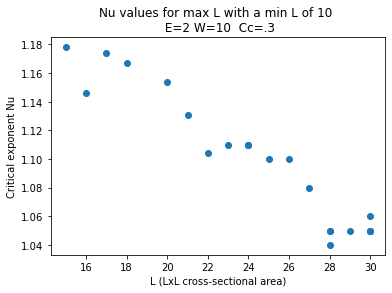

In [62]:
import pandas as pd
import matplotlib.pyplot as plt

group = 'E2W10Lz100K'
datafile=outputdir+group+'\\'+group+'_plot.csv'

print(datafile)
df = pd.read_csv(datafile,engine='python')
# maxL=df['Max L']
# minL=df['Min L']
# nu=df['Nu']
# nuErrL=df['Nu err lower']
# nuErrU=df['Nu err upper']
#print(df['Bootstrap Resample size'])
print(df.size)
df=df.loc[(df['Min L']==10) &(df['Max L']>=15)& (df['Bootstrap Resample size']>=40)&(df['Nu']<=1.5)&(df['Nu']>=1)&(df['n_R']==3)&(df['n_I']==1)&(df['m_R']==2)&(df['m_I']==1)]
print(df.size)
maxL=df['Max L']
nu=df['Nu']
plt.scatter(maxL,nu)
plt.title('Nu values for max L with a min L of 10 \n E=2 W=10  Cc=.3')
plt.xlabel('L (LxL cross-sectional area)')
plt.ylabel('Critical exponent Nu')

d:\My Documents\Academics\Zimanyi Group\All Repositories\ZG-FSS\output\E2W10Lz100K\E2W10Lz100K_plot.csv
308
308


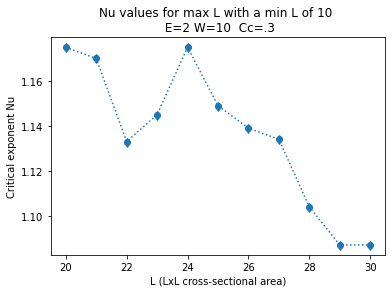

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

group = 'E2W10Lz100K'
datafile=outputdir+group+'\\'+group+'_plot.csv'

print(datafile)
df = pd.read_csv(datafile,engine='python')
# maxL=df['Max L']
# minL=df['Min L']
# nu=df['Nu']
# nuErrL=df['Nu err lower']
# nuErrU=df['Nu err upper']
#print(df['Bootstrap Resample size'])
print(df.size)
df=df.loc[(df['Min L']==10) &(df['Max L']>=15)& (df['Bootstrap Resample size']>=40)&(df['Nu']<=1.5)&(df['Nu']>=1)&(df['n_R']==3)&(df['n_I']==1)&(df['m_R']==2)&(df['m_I']==1)]
print(df.size)
maxL=df['Max L']
nu=df['Nu']

nel=df['Nu err lower']
neu=df['Nu err upper']
#yer=np.vstack((nu-nel,neu-nu))
yer=[nu-nel,neu-nu]
ba=np.array(np.ones(nu.size),dtype=bool)
#print(yer)
plt.scatter(maxL,nu)
plt.title('Nu values for max L with a min L of 10 \n E=2 W=10  Cc=.3')
plt.errorbar(maxL,nu,yerr=yer,lolims=ba,uplims=ba,linestyle='dotted')
plt.xlabel('L (LxL cross-sectional area)')
plt.ylabel('Critical exponent Nu')
plt.show()
plt.close()

In [14]:
import numpy as np
cc=0.299


upperrange=np.round((10**(np.linspace(-2,-1.1,num=5))*cc+cc),3) #-2 to -1 goes 10% away to 1% away from cc
lowerrange=np.sort(np.round((-10**(np.linspace(-2,-1.1,num=5))*cc+cc),3)) #-2 to -1 goes 10% away to 1% away from cc

out=list(lowerrange) + [cc] + list(upperrange)
print(out)

[0.275, 0.285, 0.291, 0.294, 0.296, 0.299, 0.302, 0.304, 0.307, 0.313, 0.323]
